# Exlporatory analysis of the UK Power Networks led Low Carbon London project dataset

This Notebook deal with the following exploratory elements:
1. Descriptives of the full and balanced datasets
2. Analysis of Seasonal kWh consumption
3. Analysis of ToU vs Standard consumers' kWh consumption
4. Analysis of kWh consumption during Weekday and Weekends
5. Analysis of morning, evening, night kWh consumption
6. Analysis of kWh during holiday and non-holiday periods
7. Analysis of CACI groups
8. Analysis of CACI sub-groups
9. Weather variables to include in ML models

In [1]:
# Data processing
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Statistical modelling
import scipy
import statsmodels.api as sm
from scipy import stats

## Descriptives of full dataset

In [2]:
df = pd.read_csv(r"D:\Msc BIM\Master Thesis Trajectory\Data\UK Power Networks\Processed_Date_UK_Power_Data.csv", sep="\t")
df = df.iloc[:,[1,4]]
df = df[df.iloc[:,1] != 'null']
df = df[df.iloc[:,1] != 'Null']
df = df.values
df[:,1] = df[:,1].astype(np.float)
print('Count of observations = '+ str(len(df[:,1])))
print('Count of unique smart meters = '+ str(len(set(list(df[:,0])))))
print('mean of balanced dataset = ' + str(np.mean(df[:,1])))
print('Standard Deviation of balanced dataset = ' + str(np.std(df[:,1])))
print('Minimum of balanced dataset = ' + str(np.min(df[:,1])))
print('Maximum of balanced dataset = ' + str(np.max(df[:,1])))
print('Count of 0 kWh observations = '+  str(len(df[df[:,1] == 0])))

Count of observations = 116768969
Count of unique smart meters = 5554
mean of balanced dataset = 0.2181671623189342
Standard Deviation of balanced dataset = 0.30758154208285754
Minimum of balanced dataset = 0.0
Maximum of balanced dataset = 10.7609997
Count of 0 kWh observations = 1452844


## Descriptives of Balanced Dataset

In [3]:
df = pd.read_csv("All_Data.csv", sep="\t")
# Remove observations not belonging to a Caci Group
df = df[df.Acorn != '0']
df = df[df.Acorn != 'ACORN-U']
# convert to numpy and count amount of unique smart meters
df = df.values
print('Count of observations = '+ str(len(df[:,22])))
print('Count of unique smart meters = '+ str(len(set(list(df[:,1])))))
print('mean of balanced dataset = ' + str(np.mean(df[:,22])))
print('Standard Deviation of balanced dataset = ' + str(np.std(df[:,22])))
print('Minimum of balanced dataset = ' + str(np.min(df[:,22])))
print('Maximum of balanced dataset = ' + str(np.max(df[:,22])))
print('Count of 0 kWh observations = '+  str(len(df[df[:,22] == 0])))

Count of observations = 14882778
Count of unique smart meters = 678
mean of balanced dataset = 0.22460931144381352
Standard Deviation of balanced dataset = 0.3235766275601889
Minimum of balanced dataset = 0.0
Maximum of balanced dataset = 8.170999499999999
Count of 0 kWh observations = 149195


## Distribution of kWh within the present dataset

In [4]:
df = pd.read_csv("All_Data.csv", sep="\t")
df = df[df.Acorn != '0']
df= df[df.Acorn != 'ACORN-U']
df = df[df.Year == 2013]

In [5]:
# Set tresholds points that are used to exclude outliers in distribution plot
lowest_5_percent = np.percentile(df['KWH_hh'].values, 5)
highest_5_percent = np.percentile(df['KWH_hh'].values, 95)
print(lowest_5_percent, highest_5_percent)

0.02 0.745


c:\users\gebruiker\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


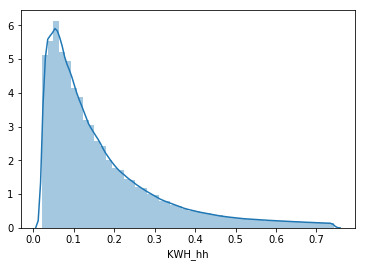

In [6]:
sns.distplot(df['KWH_hh'][(df['KWH_hh']<highest_5_percent) & (df['KWH_hh']>lowest_5_percent)])
plt.show()
# Data is positively skewwed.

## Analysis of Seasonal kWh consumption

In [7]:
df.head()

,Unnamed: 0,LCLid,Acorn,Year,Month,Day,Hour,DateTime,humidity,pressure,...,windSpeed,StdorToU,isAutumn,isSpring,isWinter,isHoliday,isPeak,isOff_Peak,isWeekend,KWH_hh
58600,58600,MAC000323,ACORN-A,2013,1,1,0.0,2013-01-01 00:00,0.74,1008.22,...,12.258,1,0,0,1,1,0,0,0,0.388
58601,58601,MAC001528,ACORN-A,2013,1,1,0.0,2013-01-01 00:00,0.74,1008.22,...,12.258,1,0,0,1,1,0,0,0,0.291
58602,58602,MAC001710,ACORN-A,2013,1,1,0.0,2013-01-01 00:00,0.74,1008.22,...,12.258,1,0,0,1,1,0,0,0,0.930
58603,58603,MAC001819,ACORN-A,2013,1,1,0.0,2013-01-01 00:00,0.74,1008.22,...,12.258,1,0,0,1,1,0,0,0,0.158
58604,58604,MAC002563,ACORN-A,2013,1,1,0.0,2013-01-01 00:00,0.74,1008.22,...,12.258,1,0,0,1,1,0,0,0,0.104


In [8]:
# Create subsets of seasonal data
Winter = df[(df['isSpring'] == 0) & (df['isWinter'] == 1) & (df['isAutumn'] == 0)]
Summer = df[(df['isSpring'] == 0) & (df['isWinter'] == 0) & (df['isAutumn'] == 0)]
Spring = df[(df['isSpring'] == 1) & (df['isWinter'] == 0) & (df['isAutumn'] == 0)]
Autumn = df[(df['isSpring'] == 0) & (df['isWinter'] == 0) & (df['isAutumn'] == 1)]

In [9]:
Sum_day = Summer.groupby('Hour').mean().iloc[:,-1] 
Win_day = Winter.groupby('Hour').mean().iloc[:,-1] 
Spr_day = Spring.groupby('Hour').mean().iloc[:,-1] 
Aut_day = Autumn.groupby('Hour').mean().iloc[:,-1] 

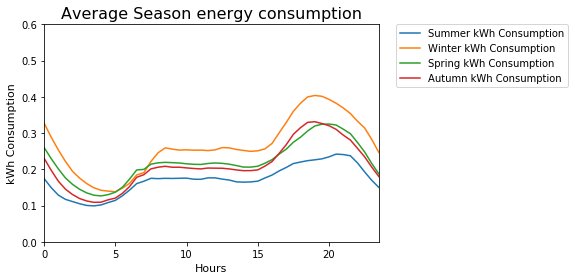

In [10]:
weekday_days = np.arange(0,24,.5)
plt.plot(weekday_days, Sum_day, label = 'Summer kWh Consumption')
plt.plot(weekday_days, Win_day, label = 'Winter kWh Consumption')
plt.plot(weekday_days, Spr_day, label = 'Spring kWh Consumption')
plt.plot(weekday_days, Aut_day, label = 'Autumn kWh Consumption')
plt.axis((0,23.5,0.00,0.6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('kWh Consumption', fontsize=11)
plt.title('Average Season energy consumption', fontsize=16)
plt.show()

In [11]:
# Return f-statistic and p-value
f, p = scipy.stats.f_oneway(Winter.loc[:,"KWH_hh"], Summer.loc[:,"KWH_hh"], Autumn.loc[:,"KWH_hh"], Spring.loc[:,"KWH_hh"])
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 45226.86659485091
P-value: 0.0


## Analysis of kWh for Time of use vs. Standard consumers

In [12]:
# Remove variables from memory and create subsets of ToU vs. Standard consumers kWh data
del Winter, Summer, Spring, Autumn

ToU = df[(df['StdorToU'] == 0)]
Std = df[(df['StdorToU'] == 1)]
ToU_kWh = ToU.groupby('Hour').mean().iloc[:,-1]
Std_kWh = Std.groupby('Hour').mean().iloc[:,-1]

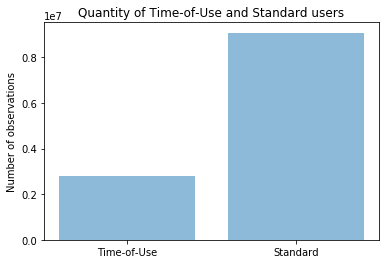

In [13]:
consumers = ('Time-of-Use', 'Standard')
y_pos = np.arange(len(consumers))
performance = [len(df[df.StdorToU == 0]), len(df[df.StdorToU == 1])]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, consumers)
plt.ylabel('Number of observations')
plt.title('Quantity of Time-of-Use and Standard users')
 
plt.show()

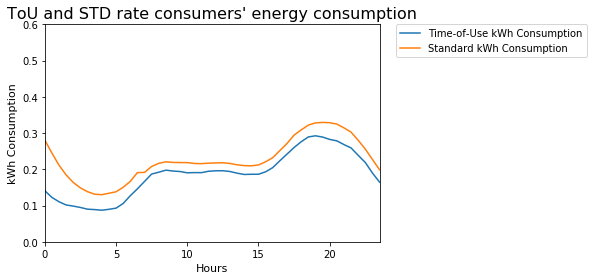

In [14]:
weekday_days = np.arange(0,24,.5)
plt.plot(weekday_days, ToU_kWh, label = 'Time-of-Use kWh Consumption')
plt.plot(weekday_days, Std_kWh, label = 'Standard kWh Consumption')
plt.axis((0,23.5,0,.6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('kWh Consumption', fontsize=11)
plt.title('ToU and STD rate consumers\' energy consumption', fontsize=16)
plt.show()

In [15]:
# Return t-statistic and p-value
t, p = scipy.stats.ttest_ind(ToU.loc[:,'KWH_hh'], Std.loc[:,'KWH_hh'], axis=0, equal_var=False, nan_policy='omit')
print("t-statistic:", t)
print("p-value:", p)

t-statistic: -190.80256377537123
p-value: 0.0


## Analysis of kWh consumption during Weekday and Weekends

In [16]:
# Remove variables from memory and create subsets of Weekday vs. Weekemd kWh data
del ToU, Std 

week_day = df[(df['isWeekend'] == 0)]
week_end = df[(df['isWeekend'] == 1)]
weekday = week_day.groupby('Hour').mean().iloc[:,-1]
weekend = week_end.groupby('Hour').mean().iloc[:,-1]

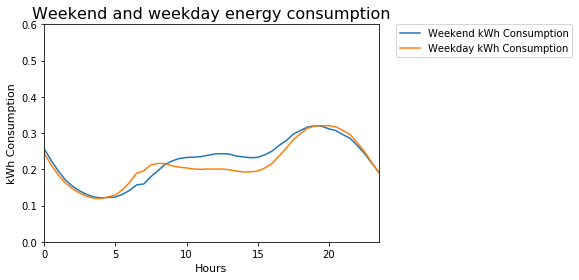

In [17]:
weekday_days = np.arange(0,24,.5)
plt.plot(weekday_days, weekend, label = 'Weekend kWh Consumption')
plt.plot(weekday_days, weekday, label = 'Weekday kWh Consumption')
plt.axis((0,23.5,0.0,0.6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('kWh Consumption', fontsize=11)
plt.title('Weekend and weekday energy consumption', fontsize=16)
plt.show()

In [18]:
# Return t-statistic and p-value
t, p = scipy.stats.ttest_ind(week_day.loc[:,'KWH_hh'], week_end.loc[:,'KWH_hh'], axis=0, equal_var=False, nan_policy='omit')
print("t-statistic:", t)
print("p-value:", p)

t-statistic: -47.52765882835166
p-value: 0.0


## Analysis of morning, evening, night kWh consumption

In [19]:
df.columns

Index(['Unnamed: 0', 'LCLid', 'Acorn', 'Year', 'Month', 'Day', 'Hour',
       'DateTime', 'humidity', 'pressure', 'temperature', 'visibility',
       'windBearing', 'windSpeed', 'StdorToU', 'isAutumn', 'isSpring',
       'isWinter', 'isHoliday', 'isPeak', 'isOff_Peak', 'isWeekend', 'KWH_hh'],
      dtype='object')

In [20]:
# Remove variables from memory and create subsets of day periods kWh data
del week_day, week_end

Off_Peak = df[(df['isOff_Peak'] == 1)]
Peak = df[(df['isPeak'] == 1)]
Night = df[(df['isOff_Peak'] == 0) & (df['isPeak'] == 0)]

In [21]:
# Make hours comparable, within the range of 0:00 and 7:30 hours
Off_Peak.Hour = Off_Peak.Hour-8
Peak.Hour = Peak.Hour-16
Night.Hour = Night.Hour

c:\users\gebruiker\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [22]:
print(set(list(Off_Peak.Hour)))
print(set(list(Peak.Hour)))
print(set(list(Night.Hour)))

{0.0, 0.5, 2.0, 1.0, 1.5, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5}
{0.0, 0.5, 2.0, 1.0, 1.5, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5}
{0.0, 0.5, 2.0, 1.0, 1.5, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5}


In [23]:
Off_Peak_kwh = Off_Peak.groupby('Hour').mean().iloc[:,-1]
Peak_kwh = Peak.groupby('Hour').mean().iloc[:,-1]
Night_kwh = Night.groupby('Hour').mean().iloc[:,-1]

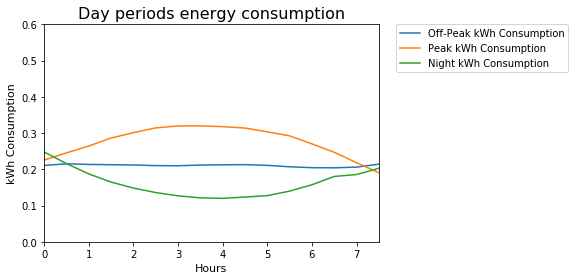

In [24]:
dayperiods = np.arange(0,8,.5)
plt.plot(dayperiods, Off_Peak_kwh, label = 'Off-Peak kWh Consumption')
plt.plot(dayperiods, Peak_kwh, label = 'Peak kWh Consumption')
plt.plot(dayperiods, Night_kwh, label = 'Night kWh Consumption')
plt.axis((0,7.5,0.0,0.6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('kWh Consumption', fontsize=11)
plt.title('Day periods energy consumption', fontsize=16)
plt.show()

In [25]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(Off_Peak.loc[:,"KWH_hh"], Peak.loc[:,"KWH_hh"], Night.loc[:,"KWH_hh"])
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 139712.97066255842
P-value: 0.0


## Analysis of kWh during holiday and non-holiday periods

In [26]:
# Remove variables from memory and create subsets of day periods kWh data
del Off_Peak, Peak, Night

Holiday = df[df['isHoliday'] == 1]
Non_Holiday = df[df['isHoliday'] == 0]

In [27]:
Holiday_kwh = Holiday.groupby('Hour').mean().iloc[:,-1]
Non_Holiday_kwh = Non_Holiday.groupby('Hour').mean().iloc[:,-1]

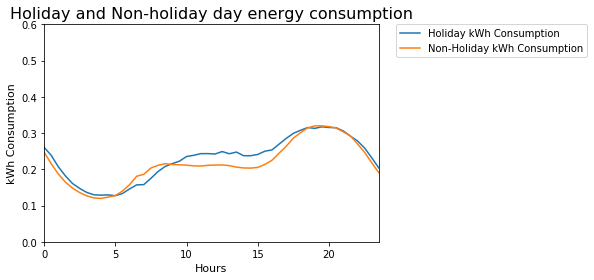

In [28]:
weekday_days = np.arange(0,24,.5)
plt.plot(weekday_days, Holiday_kwh, label = 'Holiday kWh Consumption')
plt.plot(weekday_days, Non_Holiday_kwh, label = 'Non-Holiday kWh Consumption')
plt.axis((0,23.5,0,.6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('kWh Consumption', fontsize=11)
plt.title("Holiday and Non-holiday day energy consumption", fontsize=16)
plt.show()

In [29]:
# Return t-statistic and p-value
t, p = scipy.stats.ttest_ind(Holiday.loc[:,'KWH_hh'], Non_Holiday.loc[:,'KWH_hh'], axis=0, equal_var=False, nan_policy='omit')
print("t-statistic:", t)
print("p-value:", p)

t-statistic: 18.867472450846325
p-value: 2.1172618997294212e-79


## Descrptives  of Cluster data

In [30]:
# Remove variables from memory and create subsets of CACI main categories kWh data
del Holiday, Non_Holiday

AA = df[(df.Acorn == 'ACORN-A') | (df.Acorn == 'ACORN-B') | (df.Acorn == 'ACORN-C')]
RP = df[(df.Acorn == 'ACORN-D') | (df.Acorn == 'ACORN-E')]
CC = df[(df.Acorn == 'ACORN-F') | (df.Acorn == 'ACORN-G') | (df.Acorn == 'ACORN-H') | (df.Acorn == 'ACORN-I') | (df.Acorn == 'ACORN-J')]
FS = df[(df.Acorn == 'ACORN-K') | (df.Acorn == 'ACORN-L') | (df.Acorn == 'ACORN-M') | (df.Acorn == 'ACORN-N')]
UA = df[(df.Acorn == 'ACORN-O') | (df.Acorn == 'ACORN-P') | (df.Acorn == 'ACORN-Q')]

In [31]:
AA_KWH = AA.groupby('Hour').mean().iloc[:,-1]
RP_KWH = RP.groupby('Hour').mean().iloc[:,-1]
CC_KWH = CC.groupby('Hour').mean().iloc[:,-1]
FS_KWH = FS.groupby('Hour').mean().iloc[:,-1]
UA_KWH = UA.groupby('Hour').mean().iloc[:,-1]

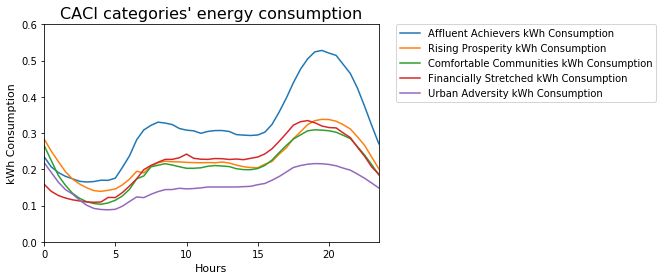

In [32]:
weekday_days = np.arange(0,24,.5)
plt.plot(weekday_days, AA_KWH, label = 'Affluent Achievers kWh Consumption')
plt.plot(weekday_days, RP_KWH, label = 'Rising Prosperity kWh Consumption')
plt.plot(weekday_days, CC_KWH, label = 'Comfortable Communities kWh Consumption')
plt.plot(weekday_days, FS_KWH, label = 'Financially Stretched kWh Consumption')
plt.plot(weekday_days, UA_KWH, label = 'Urban Adversity kWh Consumption')
plt.axis((0,23.5,0.0,0.60))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('kWh Consumption', fontsize=11)
plt.title("CACI categories' energy consumption", fontsize=16)
plt.show()

In [33]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(AA.loc[:,"KWH_hh"], RP.loc[:,"KWH_hh"], CC.loc[:,"KWH_hh"], FS.loc[:,"KWH_hh"], UA.loc[:,"KWH_hh"])
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 40129.61230683344
P-value: 0.0


## Analysis of CACI sub-groups

In [34]:
# Remove variables from memory
del AA, RP, CC, FS, UA

In [35]:
# Create and apply function that prints out summary statistic per CACI group
def descriptives(df,string):
    df = df[(df['Acorn'] == 'ACORN-'+string)]
    # convert to numpy and count amount of unique smart meters
    df = df.values
    print(string)
    print('Number of Smart Meter readings is ' + str(len(df)))
    print('Count of unique smart meters is '+ str(len(set(list(df[:,1])))))
    print('mean of Smart Meter readings is ' + str(np.mean(df[:,22])))
    print('Standard Deviation of Smart Meter readings is ' + str(np.std(df[:,22])))
    print('Minimum of Smart Meter readings is ' + str(np.min(df[:,22])))
    print('Maximum of Smart Meter readings is ' + str(np.max(df[:,22])))
    print('N. of 0 kWh readings per meter is ' + str(len(df[df[:,-1]== 0])))
caci = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q']
[descriptives(df,group) for group in caci]

A
Number of Smart Meter readings is 350640
Count of unique smart meters is 20
mean of Smart Meter readings is 0.3786441079480546
Standard Deviation of Smart Meter readings is 0.5336671667275289
Minimum of Smart Meter readings is 0.0
Maximum of Smart Meter readings is 8.170999499999999
N. of 0 kWh readings per meter is 3720
B
Number of Smart Meter readings is 87660
Count of unique smart meters is 5
mean of Smart Meter readings is 0.34913828428929566
Standard Deviation of Smart Meter readings is 0.32515083269854567
Minimum of Smart Meter readings is 0.023
Maximum of Smart Meter readings is 3.0929999
N. of 0 kWh readings per meter is 0
C
Number of Smart Meter readings is 315576
Count of unique smart meters is 18
mean of Smart Meter readings is 0.23834894920811614
Standard Deviation of Smart Meter readings is 0.2908242780571165
Minimum of Smart Meter readings is 0.0
Maximum of Smart Meter readings is 4.566
N. of 0 kWh readings per meter is 4417
D
Number of Smart Meter readings is 894132
Co

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [36]:
# Create subsets of data by CACI sub-group
A = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-A']
B = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-B']
C = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-C']
D = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-D']
E = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-E']
F = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-F']
G = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-G']
H = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-H']
I = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-I']
J = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-J']
K = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-K']
L = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-L']
M = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-M']
N = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-N']
O = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-O']
P = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-P']
Q = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-Q']

In [37]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q)
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 17594.29932816892
P-value: 0.0


## Weather variables to include in ML models

In [38]:
del A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q

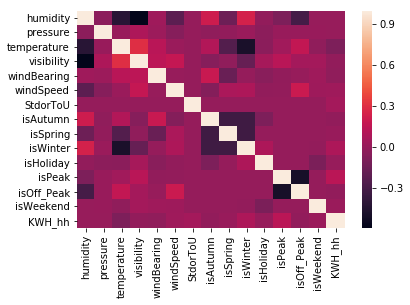

In [39]:
sns.heatmap(df[['humidity',
       'pressure', 'temperature', 'visibility', 'windBearing', 'windSpeed',
       'StdorToU', 'isAutumn', 'isSpring', 'isWinter', 'isHoliday',
       'isPeak', 'isOff_Peak', 'isWeekend', 'KWH_hh']].corr())

In [40]:
def linearModel(df, latex=False):
    X = sm.add_constant(df[['humidity', 'pressure', 'temperature', 'visibility', 'windBearing',
       'windSpeed', 'StdorToU', 'isAutumn', 'isSpring', 'isWinter',
       'isHoliday', 'isPeak', 'isOff_Peak', 'isWeekend']])
    y = df['KWH_hh']
    est = sm.OLS(y,X).fit()
    if latex == False:
        print(est.summary())
    elif latex == True:
        print(est.summary().as_latex())

In [41]:
linearModel(df,False)

                            OLS Regression Results                            
Dep. Variable:                 KWH_hh   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                 3.610e+04
Date:                Wed, 13 Jun 2018   Prob (F-statistic):               0.00
Time:                        13:25:26   Log-Likelihood:            -2.7498e+06
No. Observations:            11886696   AIC:                         5.500e+06
Df Residuals:                11886681   BIC:                         5.500e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1479      0.002     64.391      

In [42]:
linearModel(df,True)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &      KWH_hh      & \textbf{  R-squared:         } &       0.041     \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &       0.041     \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &   3.610e+04     \\
\textbf{Date:}             & Wed, 13 Jun 2018 & \textbf{  Prob (F-statistic):} &       0.00      \\
\textbf{Time:}             &     13:25:45     & \textbf{  Log-Likelihood:    } &  -2.7498e+06    \\
\textbf{No. Observations:} &     11886696     & \textbf{  AIC:               } &   5.500e+06     \\
\textbf{Df Residuals:}     &     11886681     & \textbf{  BIC:               } &   5.500e+06     \\
\textbf{Df Model:}         &          14      & \textbf{                     } &                 \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                     & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$>$$|$t$|$} & \textbf{[